In [1]:
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/



Saving kaggle.json to kaggle.json


In [2]:
!chmod 600 ~/.kaggle/kaggle.json
#unzip the folder
!mkdir train

In [3]:
!kaggle datasets download -d uciml/pima-indians-diabetes-database

  0% 0.00/8.91k [00:00<?, ?B/s]
100% 8.91k/8.91k [00:00<00:00, 3.36MB/s]


In [4]:
!unzip pima-indians-diabetes-database.zip -d train


Archive:  pima-indians-diabetes-database.zip
  inflating: train/diabetes.csv      


In [5]:
# example of a super learner model for binary classification
from numpy import hstack
from numpy import vstack
from numpy import asarray
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier


In [6]:
# load the data
data = pd.read_csv('/content/train/diabetes.csv')
df = data.copy()
feature_columns = list(df.columns)
feature_columns.remove('Outcome')
from sklearn.impute import SimpleImputer
fill_values = SimpleImputer(missing_values=0, strategy="mean", copy=False)
df[feature_columns] = fill_values.fit_transform(df[feature_columns])
# split the data into train and test
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify = y)

In [7]:
# create a list of base-models
def get_models():
	models = list()
	models.append(LogisticRegression(solver='liblinear'))
	models.append(DecisionTreeClassifier())
	models.append(SVC(gamma='scale', probability=True))
	models.append(GaussianNB())
	models.append(KNeighborsClassifier())
	models.append(AdaBoostClassifier())
	models.append(BaggingClassifier(n_estimators=10))
	models.append(RandomForestClassifier(n_estimators=10))
	models.append(ExtraTreesClassifier(n_estimators=10))
	return models
 
# collect out of fold predictions form k-fold cross validation
def get_out_of_fold_predictions(X, y, models):
	meta_X, meta_y = list(), list()
	# define split of data
	kfold = KFold(n_splits=10, shuffle=True)
	# enumerate splits
	for train_ix, test_ix in kfold.split(X):
		fold_yhats = list()
		# get data
		train_X, test_X = X[train_ix], X[test_ix]
		train_y, test_y = y[train_ix], y[test_ix]
		meta_y.extend(test_y)
		# fit and make predictions with each sub-model
		for model in models:
			model.fit(train_X, train_y)
			yhat = model.predict_proba(test_X)
			# store columns
			fold_yhats.append(yhat)
		# store fold yhats as columns
		meta_X.append(hstack(fold_yhats))
	return vstack(meta_X), asarray(meta_y)
 
# fit all base models on the training dataset
def fit_base_models(X, y, models):
	for model in models:
		model.fit(X, y)
 
# fit a meta model
def fit_meta_model(X, y):
	model = LogisticRegression(solver='liblinear')
	model.fit(X, y)
	return model
 
# evaluate a list of models on a dataset
scores = {}
def evaluate_models_enhance(X_train, X_test, y_train, y_test, models):
  for model in models:
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    scores[model.__class__.__name__] = {
        'Train': (accuracy_score(y_train, y_train_pred))*100,
        'Test': (accuracy_score(y_test, y_test_pred))*100
    }
    print(scores)


# make predictions with stacked model
def super_learner_predictions(X, models, meta_model):
	meta_X = list()
	for model in models:
		yhat = model.predict_proba(X)
		meta_X.append(yhat)
	meta_X = hstack(meta_X)
	# predict
	return meta_model.predict(meta_X)

In [8]:
print('Train', X.shape, y.shape, 'Test', X_test.shape, y_test.shape)
# get models
models = get_models()
# get out of fold predictions
meta_X, meta_y = get_out_of_fold_predictions(X, y, models)
print('Meta ', meta_X.shape, meta_y.shape)
# fit base models
fit_base_models(X_train, y_train, models)
# fit the meta model
meta_model = fit_meta_model(meta_X, meta_y)
# evaluate base models
evaluate_models_enhance(X_train, X_test, y_train, y_test, models)
# evaluate stacked model
# evaluate_models_stack(X_train, X_test, y_train, y_test, models, meta_model)
yhat_train = super_learner_predictions(X_train, models, meta_model)
yhat_test = super_learner_predictions(X_test, models, meta_model)
print("RESULTS FOR SUPER LEARNER: \n-------------------------------")
clf_report = pd.DataFrame(classification_report(y_train, yhat_train, output_dict=True))
print(f"ACCURACY SCORE ON TRAIN: {(accuracy_score(y_train, yhat_train))*100}")
print('\n')
clf_report = pd.DataFrame(classification_report(y_test, yhat_test, output_dict=True))
print(f"ACCURACY SCORE ON TEST: {(accuracy_score(y_test, yhat_test))*100}")
print("\n=================================")
 
# print('Super Learner: %.3f' % (accuracy_score(y_test, yhat) * 100))

Train (768, 8) (768,) Test (231, 8) (231,)
Meta  (768, 18) (768,)
{'LogisticRegression': {'Train': 78.58472998137802, 'Test': 73.59307359307358}}
{'LogisticRegression': {'Train': 78.58472998137802, 'Test': 73.59307359307358}, 'DecisionTreeClassifier': {'Train': 100.0, 'Test': 76.19047619047619}}
{'LogisticRegression': {'Train': 78.58472998137802, 'Test': 73.59307359307358}, 'DecisionTreeClassifier': {'Train': 100.0, 'Test': 76.19047619047619}, 'SVC': {'Train': 78.02607076350093, 'Test': 74.45887445887446}}
{'LogisticRegression': {'Train': 78.58472998137802, 'Test': 73.59307359307358}, 'DecisionTreeClassifier': {'Train': 100.0, 'Test': 76.19047619047619}, 'SVC': {'Train': 78.02607076350093, 'Test': 74.45887445887446}, 'GaussianNB': {'Train': 77.6536312849162, 'Test': 74.45887445887446}}
{'LogisticRegression': {'Train': 78.58472998137802, 'Test': 73.59307359307358}, 'DecisionTreeClassifier': {'Train': 100.0, 'Test': 76.19047619047619}, 'SVC': {'Train': 78.02607076350093, 'Test': 74.45887

In [9]:
scores['Manual_stacked'] = {
        'Train': (accuracy_score(y_train, yhat_train))*100,
        'Test': (accuracy_score(y_test, yhat_test))*100
    }
scores

{'AdaBoostClassifier': {'Test': 74.02597402597402, 'Train': 84.17132216014897},
 'BaggingClassifier': {'Test': 75.32467532467533, 'Train': 98.32402234636871},
 'DecisionTreeClassifier': {'Test': 76.19047619047619, 'Train': 100.0},
 'ExtraTreesClassifier': {'Test': 74.45887445887446, 'Train': 100.0},
 'GaussianNB': {'Test': 74.45887445887446, 'Train': 77.6536312849162},
 'KNeighborsClassifier': {'Test': 71.86147186147186,
  'Train': 80.63314711359403},
 'LogisticRegression': {'Test': 73.59307359307358, 'Train': 78.58472998137802},
 'Manual_stacked': {'Test': 75.32467532467533, 'Train': 96.46182495344506},
 'RandomForestClassifier': {'Test': 74.02597402597402,
  'Train': 97.57914338919925},
 'SVC': {'Test': 74.45887445887446, 'Train': 78.02607076350093}}

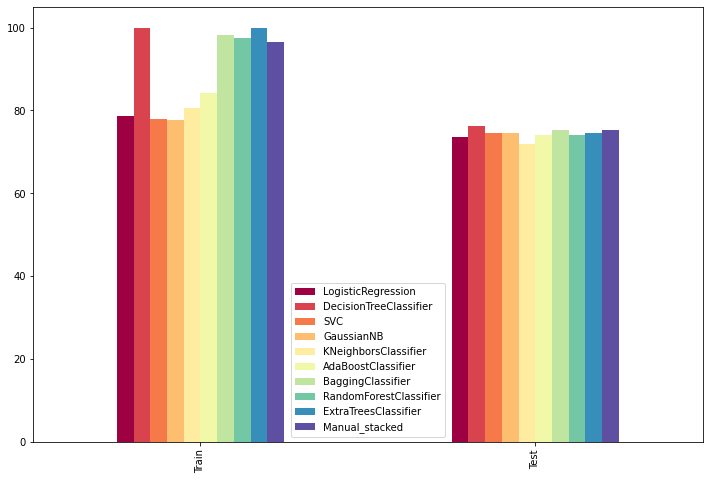

In [10]:
import matplotlib.pyplot as plt

scores_df = pd.DataFrame(scores)
long_df = scores_df.reset_index()
long_df
scores_df.plot(kind = 'bar', figsize=(12, 8), colormap='Spectral')

In [12]:
!pip install mlens

     |████████████████████████████████| 235kB 9.1MB/s 


In [34]:
from mlens.ensemble import SuperLearner
def get_super_learner(X):
  ensemble = SuperLearner(scorer=accuracy_score, folds = 10)
  model = get_models()
  ensemble.add(model)
  ensemble.add([LogisticRegression(), RandomForestClassifier()])
  ensemble.add([LogisticRegression(), SVC()])
  ensemble.add_meta(SVC())
  return ensemble

# create the super learner
ensemble = get_super_learner(X_train)
# fit the super learner
ensemble.fit(X_train, y_train)
# summarize base learners
print(ensemble.data)
# make predictions on hold out set
yhat = ensemble.predict(X_test)
print('Super Learner: %.3f' % (accuracy_score(y_test, yhat) * 100))

                                   score-m  score-s  ft-m  ft-s  pt-m  pt-s
layer-1  adaboostclassifier           0.74     0.03  0.23  0.02  0.02  0.00
layer-1  baggingclassifier            0.72     0.05  0.06  0.00  0.00  0.00
layer-1  decisiontreeclassifier       0.71     0.05  0.01  0.00  0.00  0.00
layer-1  extratreesclassifier         0.73     0.06  0.04  0.01  0.00  0.00
layer-1  gaussiannb                   0.76     0.04  0.00  0.00  0.00  0.00
layer-1  kneighborsclassifier         0.69     0.05  0.00  0.00  0.01  0.00
layer-1  logisticregression           0.77     0.05  0.01  0.00  0.00  0.00
layer-1  randomforestclassifier       0.73     0.04  0.04  0.01  0.00  0.00
layer-1  svc                          0.75     0.06  0.05  0.00  0.00  0.00
layer-2  logisticregression           0.77     0.04  0.01  0.00  0.00  0.00
layer-2  randomforestclassifier       0.74     0.04  0.37  0.07  0.02  0.00
layer-3  logisticregression           0.77     0.04  0.01  0.00  0.00  0.00
layer-3  svc

In [35]:
yhat_trainen = ensemble.predict(X_train)
yhat_testen = ensemble.predict(X_test)
print(f"ACCURACY SCORE ON TRAIN: {(accuracy_score(y_train, yhat_trainen))*100}")
print('\n')
print(f"ACCURACY SCORE ON TEST: {(accuracy_score(y_test, yhat_testen))*100}")
print("\n=================================")

ACCURACY SCORE ON TRAIN: 83.24022346368714


ACCURACY SCORE ON TEST: 76.62337662337663



In [37]:
scores['ML_stacked'] = {
        'Train': (accuracy_score(y_train, yhat_trainen))*100,
        'Test': (accuracy_score(y_test, yhat_testen))*100
    }
scores

{'AdaBoostClassifier': {'Test': 74.02597402597402, 'Train': 84.17132216014897},
 'BaggingClassifier': {'Test': 75.32467532467533, 'Train': 98.32402234636871},
 'DecisionTreeClassifier': {'Test': 76.19047619047619, 'Train': 100.0},
 'ExtraTreesClassifier': {'Test': 74.45887445887446, 'Train': 100.0},
 'GaussianNB': {'Test': 74.45887445887446, 'Train': 77.6536312849162},
 'KNeighborsClassifier': {'Test': 71.86147186147186,
  'Train': 80.63314711359403},
 'LogisticRegression': {'Test': 73.59307359307358, 'Train': 78.58472998137802},
 'ML_stacked': {'Test': 76.62337662337663, 'Train': 83.24022346368714},
 'Manual_stacked': {'Test': 75.32467532467533, 'Train': 96.46182495344506},
 'RandomForestClassifier': {'Test': 74.02597402597402,
  'Train': 97.57914338919925},
 'SVC': {'Test': 74.45887445887446, 'Train': 78.02607076350093}}

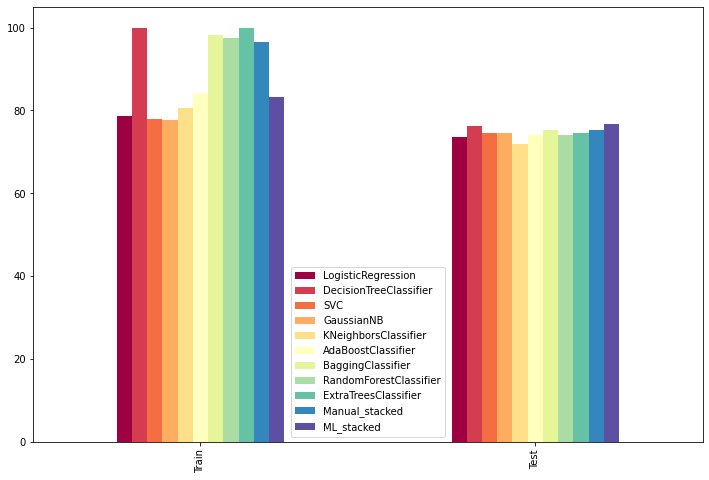

In [38]:
scores_df = pd.DataFrame(scores)
long_df = scores_df.reset_index()
long_df
scores_df.plot(kind = 'bar', figsize=(12, 8), colormap='Spectral')



---



---



In [ ]:
!pip install gradio -q

In [ ]:
import gradio as gr

In [ ]:
# scores = {}


# def convert_df(v):
#   scr = pd.DataFrame(v)
#   return scr
                
# # make predictions with stacked model
# def ploting(sc):
#   df = convert_df(sc)
#   df.plot(kind='bar')

# def evaluate(df, models):
#   models = get_models()
#   X = df.iloc[:, :-1].values
#   y = df.iloc[:, -1].values
#   X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify = y)
#   # get out of fold predictions
#   meta_X, meta_y = get_out_of_fold_predictions(X, y, models)
#   # fit base models
#   fit_base_models(X_train, y_train, models)
#   # fit the meta model
#   meta_model = fit_meta_model(meta_X, meta_y)
#   # evaluate base models
#   evaluate_models_enhance(X_train, X_test, y_train, y_test, models)
#   # evaluate stacked model
#   for model in models:
#     y_test_pred = model.predict(X_test)
#     y_train_pred = model.predict(X_train)
#     scores[model.__class__.__name__] = {
#         'Train': (accuracy_score(y_train, y_train_pred))*100,
#         'Test': (accuracy_score(y_test, y_test_pred))*100,
#     }
#   print(scores)

#   tt = evaluate(df= df, models= models)
#   tt

In [ ]:
# algos_list = [m.__class__.__name__ for m in models]
# algos_list

In [ ]:
# exa = [
#        ['scores']
# ]
# iface = gr.Interface(evaluate,
#                      [
#                       gr.inputs.Dataframe(type='pandas'),
#                       gr.inputs.Dropdown(algos_list, label='algo'),
#                       gr.inputs.Dropdown(algos_list, label='vs. algo'),
#                       gr.inputs.Radio(['train', 'test', 'both'], label='Performance'),
#                      ],
#                      gr.outputs.Image(plot=True, label='compare'), examples = exa).launch()
# # model_name = gr.inputs.CheckboxGroup(choices = lis, label="Algo name", type='value')
# # gr.Interface(super_learner_predictions, [X_train, X_test, y_train, y_test, models], "label").launch()

We will use our list of classifier models and a logistic regression model as the meta-model.

we can configure the SuperLearner with 10-fold cross-validation, our evaluation function, and the use of the entire training dataset when preparing out-of-fold predictions to use as input for the meta-model.

Then fit the data

Finally, we can get a nice report of the performance of each of the base-models on the training dataset using k-fold cross-validation by accessing the “data” attribute on the model.

In [ ]:
!pip install mlens -q

In [ ]:
from mlens.ensemble import SuperLearner

In [ ]:
def get_super_learner(X):
  ensemble = SuperLearner(scorer=accuracy_score, folds = 10, random_state=687843)
  models = get_models()
  ensemble.add(model)
  ensemble.add([LogisticRegression(), RandomForestClassifier()])
  ensemble.add([LogisticRegression(), SVC()])
  ensemble.add_meta(SVC())
  return ensemble

In [ ]:
# create the super learner
ensemble = get_super_learner(X_train)
# fit the super learner
ensemble.fit(X_train, y_train)
# summarize base learners
print(ensemble.data)
# make predictions on hold out set
yhat = ensemble.predict(X_test)
print('Super Learner: %.3f' % (accuracy_score(y_test, yhat) * 100))

In [ ]:
yhat_trainen = ensemble.predict(X_train)
yhat_testen = ensemble.predict(X_test)
print(f"ACCURACY SCORE ON TRAIN: {(accuracy_score(y_train, yhat_trainen))*100}")
print('\n')
print(f"ACCURACY SCORE ON TEST: {(accuracy_score(y_test, yhat_testen))*100}")
print("\n=================================")

In [ ]:
import matplotlib.pyplot as plt
from mlens.visualization import exp_var_plot
from sklearn.decomposition import PCA
exp_var_plot(df, PCA(), marker='s', where='post')

In [ ]:
from mlens.visualization import pca_comp_plot
pca_comp_plot(X, y)
plt.show()

In [ ]:
from mlens.visualization import pca_plot
from sklearn.decomposition import PCA
pca_plot(df, PCA(n_components=2), y=y)

In [ ]:
import matplotlib.pyplot as plt
from mlens.visualization import exp_var_plot
from sklearn.decomposition import PCA
exp_var_plot(X, PCA(), marker='s', where='post')

In [ ]:
with plt.xkcd():
  pca_comp_plot(df, y)
plt.show()

In [ ]:
from mlens.visualization import corr_X_y
# Z = df, columns=[i for i in feature_columns]
corr_X_y(df, y, 2, no_ticks=False)
plt.show()